*** Step 6 -- Model Training

In [106]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import joblib
import os

In [93]:
df = pd.read_csv(r"C:\Users\HomePC\Crypto-BuySell-Classifier-Model\notebooks\data\processed\BTCUSDT_1dmodified.csv")

In [94]:
#Define features and target variable
feature_cols = [
    'open', 'high', 'low', 'close', 'volume',
    'quote_asset_volume', 'num_trades',
    'taker_base_volume', 'taker_quote_volume',
    'return_1d', 'return_7d', 'volatility_7d',
    'rsi', 'macd', 'sma_20', 'sma_50', 'sma_200',
    'bb_high', 'bb_low', 'bb_pct',
    'stoch_rsi', 'stoch_rsi_d', 'stoch_rsi_k',
    'future_return'
]

X = df[feature_cols]
y = df["label"]
#Fix missing values
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
#Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

***Logistic Regression

In [95]:
#Logistic Regression Model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced',max_iter=1000)
model_lr.fit(X_train_scaled, y_train)


c:\Users\HomePC\Crypto-BuySell-Classifier-Model\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


*** Random forest classifier

In [96]:
# Random Forest Classifier
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42)
model_rf.fit(X_train_scaled, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


*** Catboost model

In [97]:
# CatBoost model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model_cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=0  # hide training logs
)

# Train
model_cat.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)


*** LightGBM Model

In [98]:
#LightGBM model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model_lgb = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=-1,
    objective='multiclass',
    num_class=3,
    class_weight='balanced',
    random_state=42,
    verbose=50
)

# --- Train ---
model_lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.006641
[LightGBM] [Debug] init for col-wise cost 0.000011 seconds, init for row-wise cost 0.001482 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5098
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 24
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Tr

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,100
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


*** XGBoost model

In [99]:
#XGBoost model
# --- Model ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model_xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# --- Train ---
model_xgb.fit(X_train, y_train)

c:\Users\HomePC\Crypto-BuySell-Classifier-Model\myenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:45:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


*** Step 7-Evalution of the models

In [100]:
#Evaluation of logistic regression
y_pred_lr = model_lr.predict(X_val_scaled)
print("\n=== Logistic Regression ===")
print(classification_report(y_val, y_pred_lr, digits=4))
print(confusion_matrix(y_val, y_pred_lr))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.7857    1.0000    0.8800        11
           1     0.9815    0.9464    0.9636        56
           2     1.0000    0.9231    0.9600        13

    accuracy                         0.9500        80
   macro avg     0.9224    0.9565    0.9345        80
weighted avg     0.9576    0.9500    0.9515        80

[[11  0  0]
 [ 3 53  0]
 [ 0  1 12]]


In [101]:
# Catboost Evaluation
y_pred_cat = model_cat.predict(X_val_scaled)
print("\n=== CatBoost ===")
print(classification_report(y_val, y_pred_cat, digits=4))
print(confusion_matrix(y_val, y_pred_cat))


=== CatBoost ===
              precision    recall  f1-score   support

           0     0.2558    1.0000    0.4074        11
           1     1.0000    0.0536    0.1017        56
           2     0.3824    1.0000    0.5532        13

    accuracy                         0.3375        80
   macro avg     0.5461    0.6845    0.3541        80
weighted avg     0.7973    0.3375    0.2171        80

[[11  0  0]
 [32  3 21]
 [ 0  0 13]]


In [102]:
# Evaluation of LightGBM
y_pred_lgb = model_lgb.predict(X_val_scaled)
print("\n=== LightGBM ===")
print(classification_report(y_val, y_pred_lgb, digits=4))
print(confusion_matrix(y_val, y_pred_lgb))


=== LightGBM ===
              precision    recall  f1-score   support

           0     0.2558    1.0000    0.4074        11
           1     1.0000    0.0536    0.1017        56
           2     0.3824    1.0000    0.5532        13

    accuracy                         0.3375        80
   macro avg     0.5461    0.6845    0.3541        80
weighted avg     0.7973    0.3375    0.2171        80

[[11  0  0]
 [32  3 21]
 [ 0  0 13]]


c:\Users\HomePC\Crypto-BuySell-Classifier-Model\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [103]:
# Evluation random Forest
y_pred_rf = model_rf.predict(X_val_scaled)
print("\n=== Random Forest ===")
print(classification_report(y_val, y_pred_rf, digits=4))
print(confusion_matrix(y_val, y_pred_rf))


=== Random Forest ===
              precision    recall  f1-score   support

           0     1.0000    0.9091    0.9524        11
           1     0.9655    1.0000    0.9825        56
           2     1.0000    0.9231    0.9600        13

    accuracy                         0.9750        80
   macro avg     0.9885    0.9441    0.9649        80
weighted avg     0.9759    0.9750    0.9747        80

[[10  1  0]
 [ 0 56  0]
 [ 0  1 12]]


In [104]:
#XGBoost Evaluation
y_val_pred = model_xgb.predict(X_val_scaled)
print("\n=== XGBoost ===")
print(classification_report(y_val, y_val_pred, digits=4))
print(confusion_matrix(y_val, y_val_pred))



=== XGBoost ===
              precision    recall  f1-score   support

           0     0.2558    1.0000    0.4074        11
           1     1.0000    0.0536    0.1017        56
           2     0.3824    1.0000    0.5532        13

    accuracy                         0.3375        80
   macro avg     0.5461    0.6845    0.3541        80
weighted avg     0.7973    0.3375    0.2171        80

[[11  0  0]
 [32  3 21]
 [ 0  0 13]]


# Backtesting

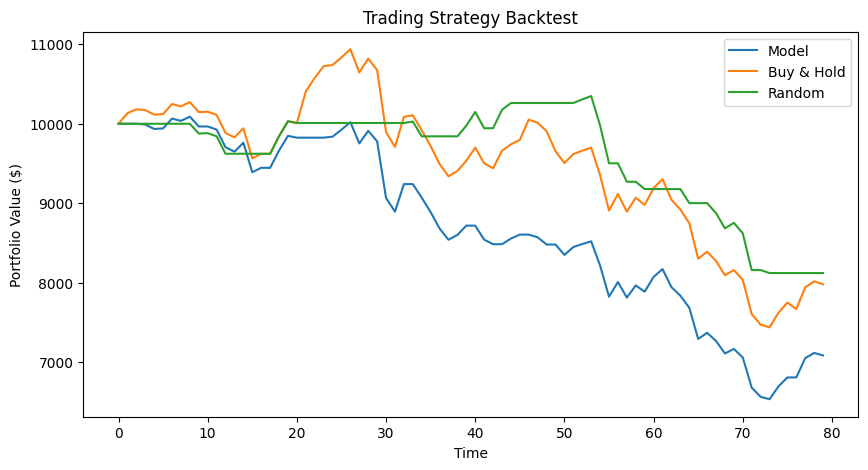

Final portfolio values:
Model: $7081.99
Buy & Hold: $7978.69
Random: $8119.74


In [107]:
# Initial capital
capital = 10000
prices = df["close"].values[-len(y_val):]  # validation period prices
signals = y_pred_xgb # replace with any model predictions: 0=HOLD, 1=BUY, 2=SELL

# Simulate strategy
def simulate(prices, signals):
    cash, coin = capital, 0
    portfolio = []
    for p, s in zip(prices, signals):
        if s == 1 and cash > 0:    # BUY
            coin, cash = cash / p, 0
        elif s == 2 and coin > 0:  # SELL
            cash, coin = coin * p, 0
        portfolio.append(cash + coin * p)
    return portfolio

model_portfolio = simulate(prices, signals)
buy_hold_portfolio = [capital / prices[0] * p for p in prices]
random_portfolio = simulate(prices, np.random.choice([0,1,2], len(prices)))

# Plot results
plt.figure(figsize=(10,5))
plt.plot(model_portfolio, label="Model")
plt.plot(buy_hold_portfolio, label="Buy & Hold")
plt.plot(random_portfolio, label="Random")
plt.xlabel("Time")
plt.ylabel("Portfolio Value ($)")
plt.title("Trading Strategy Backtest")
plt.legend()
plt.show()

# Final results
print("Final portfolio values:")
print(f"Model: ${model_portfolio[-1]:.2f}")
print(f"Buy & Hold: ${buy_hold_portfolio[-1]:.2f}")
print(f"Random: ${random_portfolio[-1]:.2f}")